In [20]:
import keras as keras
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [21]:
pd.set_option('display.width', 500)
np.set_printoptions(linewidth=500)
pd.set_option('display.max_columns', 10)

df = pd.read_csv(
    "../../dataset_building/paris_velib_dataset_preprocessed.csv",
    index_col=False
)

df.shape

df.head()

,is_installed,is_renting,is_returning,longitude,latitude,...,record_timestamp_minute_46,record_timestamp_minute_50,record_timestamp_minute_51,record_timestamp_minute_59,record_timestamp_second_0
0,1,1,1,0.023661,0.488710,...,1,0,0,0,1
1,1,1,1,0.023360,0.488375,...,1,0,0,0,1
2,1,1,1,0.023520,0.488439,...,1,0,0,0,1
3,1,1,1,0.023851,0.489104,...,1,0,0,0,1
4,1,1,1,0.023768,0.488158,...,1,0,0,0,1


In [22]:
# 30% of data for testing
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

66949 28693


In [23]:
feature_columns = list(df.columns)
feature_columns.remove('bike_availability_ratio')

f_columns = feature_columns
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
    train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
    test[f_columns].to_numpy()
)

bike_availability_col = ['bike_availability_ratio']
availability_transformer = RobustScaler()
availability_transformer = availability_transformer.fit(train[bike_availability_col])
train.loc[:, bike_availability_col] = availability_transformer.transform(
    train[bike_availability_col]
)
test.loc[:, bike_availability_col] = availability_transformer.transform(
    test[bike_availability_col]
)

C:\Users\teoma\PycharmProjects\RealtimePredictionBikeTerminalAvailability\venv\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\teoma\PycharmProjects\RealtimePredictionBikeTerminalAvailability\venv\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\teoma\PycharmProjects\RealtimePredictio

In [24]:
print("feature columns: ")
feature_columns

feature columns: 


['is_installed',
 'is_renting',
 'is_returning',
 'longitude',
 'latitude',
 'record_timestamp_year_2021',
 'record_timestamp_month_12',
 'record_timestamp_day_5',
 'record_timestamp_day_10',
 'record_timestamp_day_11',
 'record_timestamp_hour_1',
 'record_timestamp_hour_2',
 'record_timestamp_hour_3',
 'record_timestamp_hour_4',
 'record_timestamp_hour_5',
 'record_timestamp_hour_6',
 'record_timestamp_hour_7',
 'record_timestamp_hour_8',
 'record_timestamp_hour_9',
 'record_timestamp_hour_10',
 'record_timestamp_hour_11',
 'record_timestamp_hour_12',
 'record_timestamp_hour_13',
 'record_timestamp_hour_14',
 'record_timestamp_hour_15',
 'record_timestamp_hour_16',
 'record_timestamp_hour_17',
 'record_timestamp_hour_18',
 'record_timestamp_minute_13',
 'record_timestamp_minute_14',
 'record_timestamp_minute_21',
 'record_timestamp_minute_29',
 'record_timestamp_minute_43',
 'record_timestamp_minute_44',
 'record_timestamp_minute_46',
 'record_timestamp_minute_50',
 'record_timestamp_

In [25]:
print("train: ")
train

train: 


,is_installed,is_renting,is_returning,longitude,latitude,...,record_timestamp_minute_46,record_timestamp_minute_50,record_timestamp_minute_51,record_timestamp_minute_59,record_timestamp_second_0
0,0.0,0.0,0.0,0.298961,0.305764,...,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,-0.106962,-0.507686,...,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.108101,-0.353166,...,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.555875,1.260859,...,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.443415,-1.034894,...,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
66944,0.0,0.0,0.0,1.381187,-0.921276,...,0.0,0.0,0.0,0.0,0.0
66945,0.0,0.0,0.0,0.412533,0.939975,...,0.0,0.0,0.0,0.0,0.0
66946,0.0,0.0,0.0,-0.033684,0.110011,...,0.0,0.0,0.0,0.0,0.0
66947,0.0,0.0,0.0,0.059866,0.211059,...,0.0,0.0,0.0,0.0,0.0


In [26]:
print("test: ")
test

test: 


,is_installed,is_renting,is_returning,longitude,latitude,...,record_timestamp_minute_46,record_timestamp_minute_50,record_timestamp_minute_51,record_timestamp_minute_59,record_timestamp_second_0
66949,0.0,0.0,0.0,0.040418,0.735125,...,0.0,0.0,0.0,0.0,0.0
66950,0.0,0.0,0.0,-1.823201,0.102180,...,0.0,0.0,0.0,0.0,0.0
66951,0.0,0.0,0.0,1.925354,0.310920,...,0.0,0.0,0.0,0.0,0.0
66952,0.0,0.0,0.0,-1.164115,1.328333,...,0.0,0.0,0.0,0.0,0.0
66953,0.0,0.0,0.0,-0.047197,0.212935,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95637,0.0,0.0,0.0,-0.714968,-1.483773,...,0.0,0.0,0.0,0.0,0.0
95638,0.0,0.0,0.0,-0.952234,1.324407,...,0.0,0.0,0.0,0.0,0.0
95639,0.0,0.0,0.0,-0.451102,0.929310,...,0.0,0.0,0.0,0.0,0.0
95640,0.0,0.0,0.0,-0.648813,1.301191,...,0.0,0.0,0.0,0.0,0.0


In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [28]:
time_steps = 10
X_train, y_train = create_dataset(train, train.bike_availability_ratio, time_steps)
X_test, y_test = create_dataset(test, test.bike_availability_ratio, time_steps)
print(X_train.shape, y_train.shape)

(66939, 10, 40) (66939,)


In [29]:
X_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [30]:
X_test

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

In [31]:
y_train

array([-0.21163644, -0.49788007,  1.06117505, ...,  1.06117505, -0.51733352, -0.30701393])

In [32]:
y_test

array([ 0.36826166,  0.17928528, -0.35614779, ...,  1.02337977,  1.09267111,  0.52967898])

In [33]:
model = keras.Sequential()
model.add(
    keras.layers.LSTM(
        units=50,
        dropout=0.5,
        recurrent_dropout=0.2,
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop',metrics=[tf.keras.losses.MeanSquaredError(),'mae'])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
1883/1883 [==============================] - 14s 7ms/step - loss: 0.3584 - mean_squared_error: 0.3584 - mae: 0.5143 - val_loss: 0.3196 - val_mean_squared_error: 0.3201 - val_mae: 0.4872
Epoch 2/20
1883/1883 [==============================] - 11s 6ms/step - loss: 0.3554 - mean_squared_error: 0.3554 - mae: 0.5130 - val_loss: 0.3189 - val_mean_squared_error: 0.3194 - val_mae: 0.4842
Epoch 3/20
1883/1883 [==============================] - 11s 6ms/step - loss: 0.3544 - mean_squared_error: 0.3544 - mae: 0.5124 - val_loss: 0.3189 - val_mean_squared_error: 0.3194 - val_mae: 0.4849
Epoch 4/20
1883/1883 [==============================] - 11s 6ms/step - loss: 0.3539 - mean_squared_error: 0.3539 - mae: 0.5121 - val_loss: 0.3180 - val_mean_squared_error: 0.3185 - val_mae: 0.4829
Epoch 5/20
1883/1883 [==============================] - 11s 6ms/step - loss: 0.3532 - mean_squared_error: 0.3532 - mae: 0.5117 - val_loss: 0.3179 - val_mean_squared_error: 0.3184 - val_mae: 0.4834
Epoch 6/20
1883

In [34]:
np.abs(model.evaluate(X_train, y_train)[1]-model.evaluate(X_test, y_test)[1])

897/897 [==============================] - 2s 2ms/step - loss: 0.3711 - mean_squared_error: 0.3712 - mae: 0.5330


0.028165310621261597

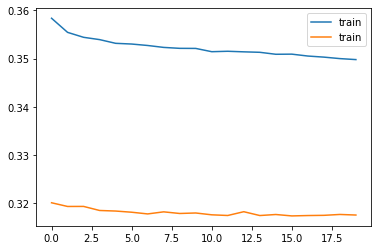

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='train')
plt.legend();

In [36]:
y_pred = model.predict(X_test)

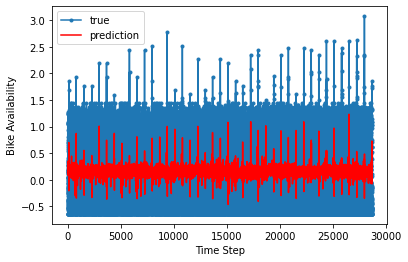

In [37]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Bike Availability')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [38]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred, sample_weight=None, multioutput="uniform_average"))

Mean Absolute Error: 0.532991702739003
